In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#plots means and trends of different variables for seasonal climatologies (not just EP days)

In [ ]:
dv=xr.open_dataset(dir+'era_5_annual_mslp_neusa.nc')
print(dv)
slp=dv.msl

In [27]:
#ds1=xr.open_dataset(dir+'ivt_basics_neusa_95_summer.nc')
ds1=xr.open_dataset(dir+'ivt_basics_neusa.nc')
ivt_mag=ds1['ivt_mag']
ivtx=ds1['ivtx']
ivty=ds1['ivty']

In [ ]:
yrs_neusa=np.arange(1979,2020,1)
season='fall'
for i in range(len(yrs_neusa)):
    print(1979+i)
    year=yrs_neusa[i]
    if season=='winter':
        if year%4==0:
            feb_length=29
        else:
            feb_length=28
        base_date_1=dt.datetime(year-1,12,1,6)
        dates_list_1=[base_date_1+dt.timedelta(days=x) for x in range(31)]

        base_date_2=dt.datetime(year,1,1,6)
        dates_list_2=[base_date_2+dt.timedelta(days=x) for x in range(31+feb_length)]

        dates_list=dates_list_1+dates_list_2

    if season=='spring':
        base_date=dt.datetime(year,3,1,6)
        dates_list=[base_date+dt.timedelta(days=x) for x in range(31+30+31)]

    if season=='summer':
        base_date=dt.datetime(year,6,1,6)
        dates_list=[base_date+dt.timedelta(days=x) for x in range(30+31+31)]

    if season=='fall':
        base_date=dt.datetime(year,9,1,6)
        dates_list=[base_date+dt.timedelta(days=x) for x in range(30+31+30)]
    
    slp_year=slp.sel(time=dates_list)
    print(slp_year)
    ivtx_year=ivtx.sel(time=dates_list)
    ivty_year=ivty.sel(time=dates_list)
    
    slp_mean=slp_year.mean(dim='time',skipna=True)
    ivtx_mean=ivtx_year.mean(dim='time',skipna=True)
    ivty_mean=ivty_year.mean(dim='time',skipna=True)
              
    if i==0:
        slp_annual_means=slp_mean
        ivtx_annual_means=ivtx_mean
        ivty_annual_means=ivty_mean
    else:
        slp_annual_means=xr.concat([slp_annual_means,slp_mean],dim='time')
        ivtx_annual_means=xr.concat([ivtx_annual_means,ivtx_mean],dim='time')
        ivty_annual_means=xr.concat([ivty_annual_means,ivty_mean],dim='time')
print(slp_annual_means)

In [ ]:
print(slp)

In [5]:
#@author: Michael Schramm on GitHub
#This function is derived from code originally posted by Sat Kumar Tomer
#(satkumartomer@gmail.com)
#See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
from scipy.stats import norm
import scipy.stats as st
def mk_test(x, alpha=0.05):
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [29]:
slp_annual_means=slp_annual_means/100.
print(slp_annual_means.max().values)

1023.13513


In [ ]:
slopes_array=xr.zeros_like(slp[0,:,:])
sigs_array=xr.zeros_like(slp[0,:,:])
sigs_array_10=xr.zeros_like(slp[0,:,:])

slopes_array_ivtx=xr.zeros_like(ivtx[0,:,:])
sigs_array_ivtx=xr.zeros_like(ivtx[0,:,:])
sigs_array_10_ivtx=xr.zeros_like(ivtx[0,:,:])

slopes_array_ivty=xr.zeros_like(ivty[0,:,:])
sigs_array_ivty=xr.zeros_like(ivty[0,:,:])
sigs_array_10_ivty=xr.zeros_like(ivty[0,:,:])
for i in range(slp.latitude.size):
    print(i)
    for j in range(slp.longitude.size):
        time_series=slp_annual_means[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_series)
        slope=linreg[0]
        p_value=linreg[3]
        mk_result=mk_test(time_series,alpha=0.05)[0]
        mk_result1=mk_test(time_series,alpha=0.10)[0]
        slopes_array[i,j]=slope
        if mk_result in ['increasing','decreasing']:
            sigs_array[i,j]=1
        if mk_result1 in ['increasing','decreasing']:
            sigs_array_10[i,j]=1
            
for i in range(ivtx.latitude.size):
    print(i)
    for j in range(ivtx.longitude.size):
        time_series=ivtx_annual_means[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_series)
        slope=linreg[0]
        p_value=linreg[3]
        mk_result=mk_test(time_series,alpha=0.05)[0]
        mk_result1=mk_test(time_series,alpha=0.10)[0]
        slopes_array_ivtx[i,j]=slope
        if mk_result in ['increasing','decreasing']:
            sigs_array_ivtx[i,j]=1
        if mk_result1 in ['increasing','decreasing']:
            sigs_array_10_ivtx[i,j]=1
            
        time_series=ivty_annual_means[:,i,j].values.tolist()
        linreg=st.linregress(np.arange(1979,2020,1),time_series)
        slope=linreg[0]
        p_value=linreg[3]
        mk_result=mk_test(time_series,alpha=0.05)[0]
        mk_result1=mk_test(time_series,alpha=0.10)[0]
        slopes_array_ivty[i,j]=slope
        if mk_result in ['increasing','decreasing']:
            sigs_array_ivty[i,j]=1
        if mk_result1 in ['increasing','decreasing']:
            sigs_array_10_ivty[i,j]=1

(-115, -30)
(12, 59)


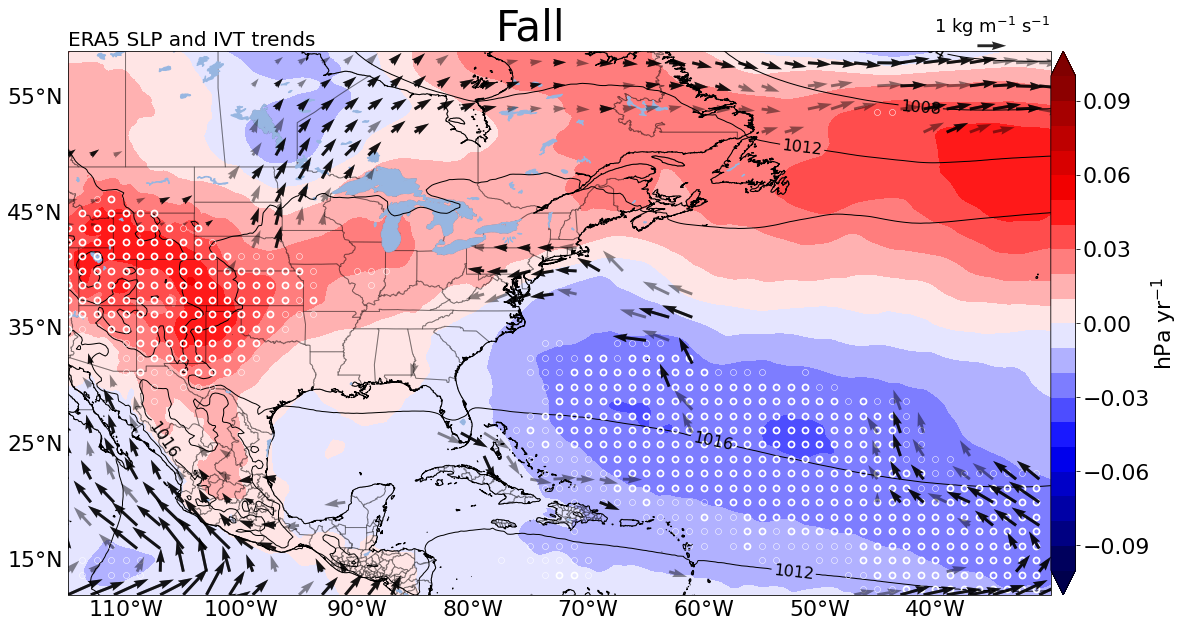

In [31]:
proj_map = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,10))
ax=plt.subplot(1,1,1,projection=proj_map)

cax=ax.contourf(slp.longitude,slp.latitude,slopes_array,transform=ccrs.PlateCarree(),levels=np.arange(-0.1,0.11,0.01),extend='both',cmap=plt.cm.seismic)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('hPa yr$^{-1}$',fontsize=22,rotation=90,labelpad=0)
cbar.ax.tick_params(labelsize=20)  
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES.with_scale('10m'),alpha=0.3)
ax.add_feature(cfeature.LAKES.with_scale('50m'))
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
    
latmin=12
latmax=59
lonmin=-115
lonmax=-30
print((lonmin,lonmax))
print((latmin,latmax))
ax.set_xlim(lonmin,lonmax)
ax.set_ylim(latmin,latmax)
ax.set_title('ERA5 SLP and IVT trends',loc='left',fontsize=20)
ax.text(-78,60,'Fall',fontsize=42)

Y=5
for i in range(int(slopes_array.longitude.size/Y)):
    for j in range(int(slopes_array.latitude.size/Y)):
        if sigs_array[Y*j,Y*i]==1:
            ax.plot(slopes_array.longitude.values[Y*i],slopes_array.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=1.75,markersize=6,markerfacecolor="None")
        else:
            if sigs_array_10[Y*j,Y*i]==1:
                if slopes_array[Y*j,Y*i]>0:
                    ax.plot(slopes_array.longitude.values[Y*i],slopes_array.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")
                if slopes_array[Y*j,Y*i]<0:
                    ax.plot(slopes_array.longitude.values[Y*i],slopes_array.latitude.values[Y*j],transform=ccrs.PlateCarree(),marker='o',color='w',mew=0.5,markersize=6,markerfacecolor="None")
        

#for i in range(int(slopes_array.longitude.size/Y)):
#    for j in range(int(slopes_array.latitude.size/Y)):
#        if sigs_array_v[Y*j,Y*i]==1 or sigs_array_u[Y*j,Y*i]==1:
#            print('YES')
#            
#            ax.quiver(u1.longitude[Y*i],u1.longitude[Y*j],slopes_array_u[Y*j,Y*i],slopes_array_v[Y*j,Y*i])
#        else:
#            if sigs_array_v_10[Y*j,Y*i]==1 or sigs_array_u_10[Y*j,Y*i]==1:
#                print('YES')
#                ax.quiver(u1.longitude[Y*i],u1.longitude[Y*j],slopes_array_u[Y*j,Y*i],slopes_array_v[Y*j,Y*i])

sigs_array_u=sigs_array_ivtx
sigs_array_v=sigs_array_ivty
sigs_array_u10=sigs_array_10_ivtx
sigs_array_v10=sigs_array_10_ivty
slopes_array_u=slopes_array_ivtx
slopes_array_v=slopes_array_ivty

sig_uv=sigs_array_u+sigs_array_v
sig_uv10=sigs_array_u10+sigs_array_v10

X=8
slopes_array_u10_select=slopes_array_u.where(sig_uv10>0)
slopes_array_v10_select=slopes_array_v.where(sig_uv10>0)
q=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,slopes_array_u10_select[0::X,0::X].values,slopes_array_v10_select[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=2.5,width=0.04,alpha=0.45,zorder=30)

slopes_array_u_select=slopes_array_u.where(sig_uv>0)
slopes_array_v_select=slopes_array_v.where(sig_uv>0)
q=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,slopes_array_u_select[0::X,0::X].values,slopes_array_v_select[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=2.5,width=0.04,alpha=0.85,zorder=30)
ax.quiverkey(q,0.94,1.01,1,'1 kg m$^{-1}$ s$^{-1}$',fontproperties={'size':18})

xticks = [-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10]
yticks = [5, 15, 25, 35, 45, 55]
ax.tick_params(labelsize=22)

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=22) 
g1.xlabel_style={'size':22,'color':'k'}
g1.ylabel_style={'size':22,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator(xticks)
g1.ylocator = mticker.FixedLocator(yticks)
g1.top_labels=False
g1.right_labels=False

slp_means_all=slp_annual_means.mean(dim='time',skipna=True)
c=ax.contour(slp_annual_means.longitude,slp_annual_means.latitude,slp_means_all,linewidths=1.0,transform=ccrs.PlateCarree(),colors='k',levels=np.arange(960,1040,4))
plt.clabel(c,fmt='%.00f',fontsize=16)

#ax.text(lonmax+15,clat,'mm/day',ha='right',va='center',rotation=270,fontsize=14)
plt.show()

#done: fall, spring, summer, winter

In [32]:
fig.savefig(dir+'neusa_large_scale_trends_seasons_4a.png')

(-115, -30)
(12, 59)


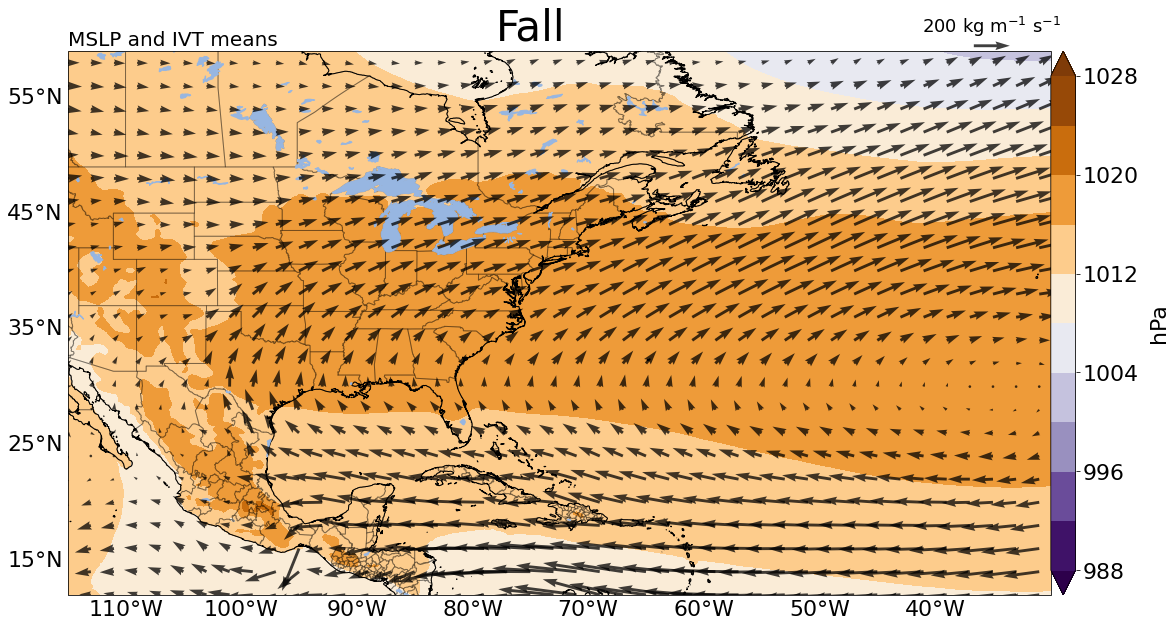

In [105]:
mslp_mean_all=slp_annual_means.mean(dim='time',skipna=True)
ivtx_mean_all=ivtx_annual_means.mean(dim='time',skipna=True)
ivty_mean_all=ivty_annual_means.mean(dim='time',skipna=True)


proj_map = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,10))
ax=plt.subplot(1,1,1,projection=proj_map)

cax=ax.contourf(slp.longitude,slp.latitude,mslp_mean_all,transform=ccrs.PlateCarree(),levels=np.arange(988,1032,4),extend='both',cmap=plt.cm.PuOr_r)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('hPa',fontsize=22,rotation=90,labelpad=10)
cbar.ax.tick_params(labelsize=20)  
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.STATES.with_scale('10m'),alpha=0.3)
ax.add_feature(cfeature.LAKES.with_scale('50m'))
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
    
latmin=12
latmax=59
lonmin=-115
lonmax=-30
print((lonmin,lonmax))
print((latmin,latmax))
ax.set_xlim(lonmin,lonmax)
ax.set_ylim(latmin,latmax)
ax.set_title('MSLP and IVT means',loc='left',fontsize=20)
ax.text(-78,60,'Fall',fontsize=42)


X=8
q=ax.quiver(ivtx.longitude[0::X].values,ivtx.latitude[0::X].values,ivtx_mean_all[0::X,0::X].values,ivty_mean_all[0::X,0::X].values,transform=ccrs.PlateCarree(),units='inches',scale=400,width=0.04,alpha=0.75,zorder=30)
ax.quiverkey(q,0.94,1.01,200,'200 kg m$^{-1}$ s$^{-1}$',fontproperties={'size':18})

xticks = [-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10]
yticks = [5, 15, 25, 35, 45, 55]
ax.tick_params(labelsize=22)

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=22) 
g1.xlabel_style={'size':22,'color':'k'}
g1.ylabel_style={'size':22,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator(xticks)
g1.ylocator = mticker.FixedLocator(yticks)
g1.top_labels=False
g1.right_labels=False

#ax.text(lonmax+15,clat,'mm/day',ha='right',va='center',rotation=270,fontsize=14)
plt.show()

#done: fall, spring, summer, winter

In [106]:
fig.savefig(dir+'neusa_large_scale_means_seasons_4.png')